## Load Data

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
df=pd.read_csv('images.csv')
df.head()

,image,sender_id,label,kids
0,4285fab0-751a-4b74-8e9b-43af05deee22,124,Not sure,False
1,ea7b6656-3f84-4eb3-9099-23e623fc1018,148,T-Shirt,False
2,00627a3f-0477-401c-95eb-92642cbe078d,94,Not sure,False
3,ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa,43,T-Shirt,False
4,3b86d877-2b9e-4c8b-a6a2-1d87513309d0,189,Shoes,False


## Data Preprocessing
Check if there is any missing value in the dataset

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5403 entries, 0 to 5402
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   image      5403 non-null   object
 1   sender_id  5403 non-null   int64 
 2   label      5403 non-null   object
 3   kids       5403 non-null   bool  
dtypes: bool(1), int64(1), object(2)
memory usage: 132.0+ KB


### Add .jpg to the image and drop columns that are not useful for the model kids , sender_id

In [4]:
## add .jpg to the image_id
df['image']=df['image'].apply(lambda x: x+'.jpg')
# drop columns that are not useful for the model kids , sender_id
df=df.drop(['kids','sender_id'],axis=1)

### Draw label distribution

<AxesSubplot:>

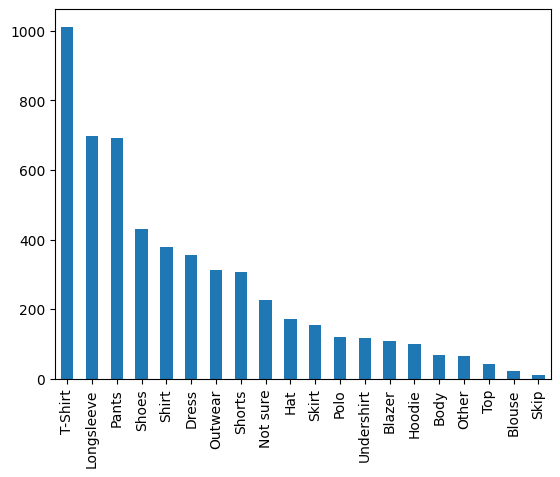

In [5]:
df['label'].value_counts().plot(kind='bar')

### Drop rows that have label 'Skip','Not sure','Other' because these are not useful as labels and could make the model confused

<AxesSubplot:>

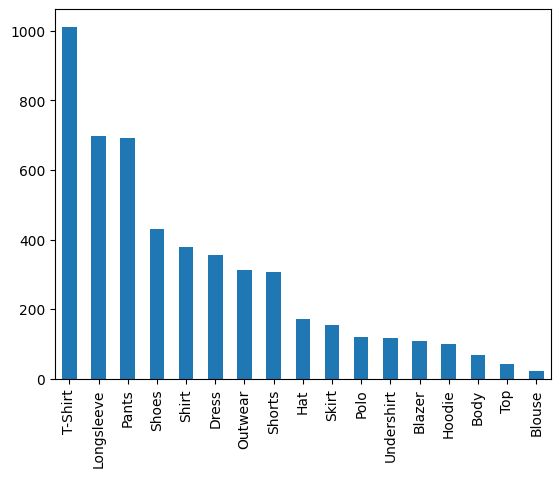

In [6]:
# we should drop these columns ['skip','Not sure','Other'] because these are not useful as labels and could make the model confused
df=df[df['label']!='Skip']
df=df[df['label']!='Not sure']
df=df[df['label']!='Other']
df['label'].value_counts().plot(kind='bar')

## Split the dataset into train ,validation and test

In [7]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42,stratify=train_df['label'])
print(f"train_df shape: {train_df.shape}")
print(f"val_df shape: {val_df.shape}")
print(f"test_df shape: {test_df.shape}")

train_df shape: (3260, 2)
val_df shape: (816, 2)
test_df shape: (1020, 2)


## Load the images using ImageDataGenerator and flow_from_dataframe to load the images from the dataframe and make folder for each label for the test data to can use it while calculating the confusion matrix

In [8]:
import shutil
import os
import numpy as np
os.makedirs('test_data_unbalanced',exist_ok=True)
for label in np.unique(test_df['label']):
    os.makedirs(f'test_data_unbalanced/{label}',exist_ok=True)
for i in range(len(test_df)):
    shutil.copyfile(f'images_compressed/{test_df.iloc[i,0]}',f'test_data_unbalanced/{test_df.iloc[i,1]}/{df.iloc[i,0]}')

In [43]:
from keras.preprocessing.image import ImageDataGenerator
train_data_loader = ImageDataGenerator(rescale=1./255)
val_data_loader = ImageDataGenerator(rescale=1./255)
import tensorflow as tf
batch_size = 16
target_size = (224, 224)
number_of_classes = 17

train_data_without_augmentation = train_data_loader.flow_from_dataframe(
    dataframe=train_df,
    directory=r"Kaggle_dataset/images_compressed",
    x_col="image",
    y_col="label",
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',)
val_data = val_data_loader.flow_from_dataframe(
    dataframe=val_df,
    directory=r"Kaggle_dataset/images_compressed",
    x_col="image",
    y_col="label",
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',)

test_data_unbalanced = tf.keras.preprocessing.image_dataset_from_directory(
    directory='Kaggle_dataset/test_data_unbalanced',
    labels='inferred',
    label_mode='categorical',
    batch_size=16,
    image_size=(224, 224),
)
def process(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

test_data_unbalanced = test_data_unbalanced.map(process)

Found 3260 validated image filenames belonging to 17 classes.
Found 816 validated image filenames belonging to 17 classes.
Found 1020 files belonging to 17 classes.


## Baseline model without any changing

In [24]:
import keras
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization,Input,InputLayer
inputs = Input(shape=(224,224,3))
x = Conv2D(filters=128,kernel_size=(3,3),activation='relu')(inputs)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Conv2D(filters=128,kernel_size=(3,3),activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Conv2D(filters=64,kernel_size=(3,3),activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Flatten()(x)
x = Dense(units=64,activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(units=17,activation='softmax')(x)
base_model = keras.Model(inputs=inputs, outputs=outputs)
base_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
base_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 128)     3584      
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 128)    512       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 128)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 128)     147584    
                                                                 
 batch_normalization_1 (Batc  (None, 109, 109, 128)    512   

In [11]:
os.makedirs('base_model_checkpoints',exist_ok=True)
checkpoint_path = 'base_model_checkpoints/checkpoint'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                save_weights_only=True,
                                                save_best_only=True,
                                                monitor='val_accuracy',
                                                verbose=1)

In [12]:
!pip install livelossplot

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python3 -m pip install --upgrade pip


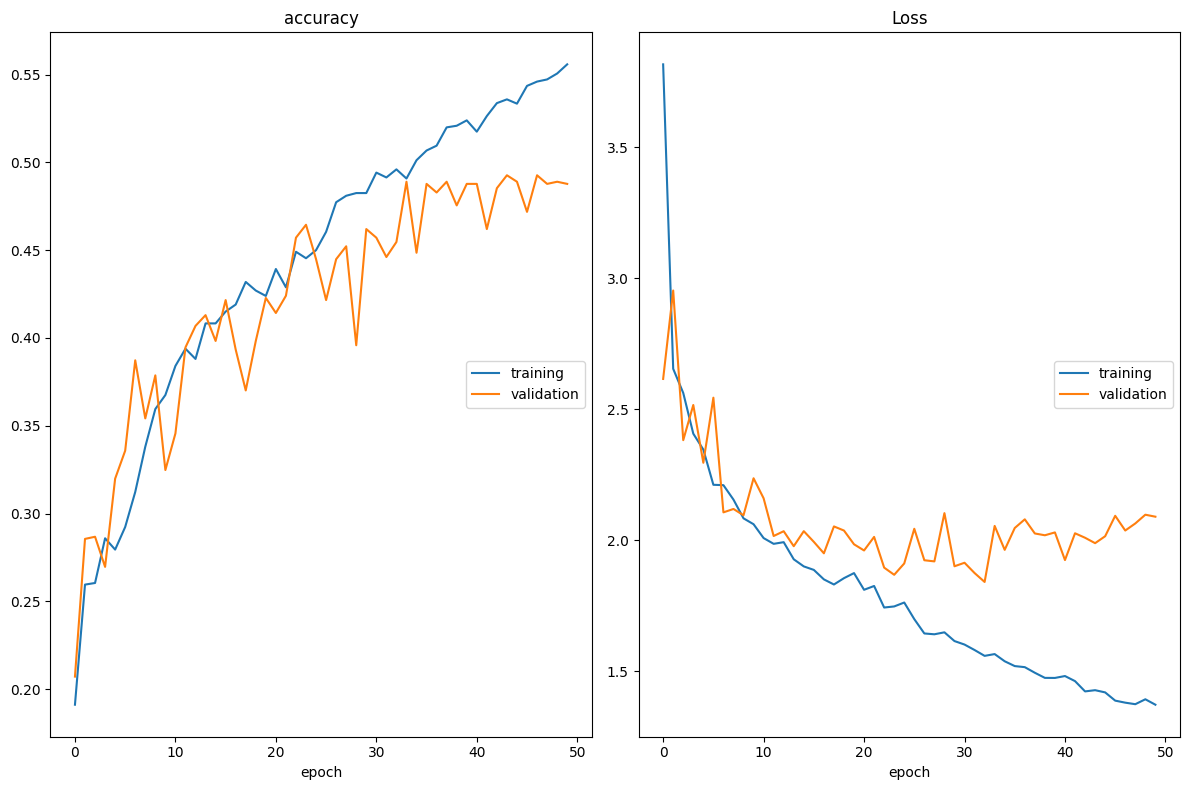

accuracy
	training         	 (min:    0.191, max:    0.556, cur:    0.556)
	validation       	 (min:    0.207, max:    0.493, cur:    0.488)
Loss
	training         	 (min:    1.372, max:    3.816, cur:    1.372)
	validation       	 (min:    1.840, max:    2.953, cur:    2.089)

Epoch 50: val_accuracy did not improve from 0.49265
64/64 [==============================] - 1s 21ms/step - loss: 2.0975 - accuracy: 0.4618


[2.0974838733673096, 0.46176469326019287]

In [13]:
from livelossplot import PlotLossesKeras
base_model_plot_losses = PlotLossesKeras()
base_model.fit(train_data_without_augmentation, validation_data=val_data, epochs=50,callbacks=[base_model_plot_losses,checkpoint_callback])
base_model.evaluate(test_data_unbalanced)

In [14]:
train_data_without_augmentation.class_indices

{'Blazer': 0,
 'Blouse': 1,
 'Body': 2,
 'Dress': 3,
 'Hat': 4,
 'Hoodie': 5,
 'Longsleeve': 6,
 'Outwear': 7,
 'Pants': 8,
 'Polo': 9,
 'Shirt': 10,
 'Shoes': 11,
 'Shorts': 12,
 'Skirt': 13,
 'T-Shirt': 14,
 'Top': 15,
 'Undershirt': 16}

In [11]:
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix,classification_report
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
def calculate_confusion_matrix(model,dataset):
    y_pred=[]
    all_labels=[]
    for batch in dataset :
        data,labels=batch
        y=model.predict(data).argmax(axis=1)
        for l,p in zip(labels.cpu().numpy().argmax(axis=1),y):
            all_labels.append(int(l))
            y_pred.append(int(p))
    ConfusionMatrixDisplay(confusion_matrix(all_labels,y_pred)).plot()
    plt.grid(False)
    plt.show()
    print(classification_report(all_labels,y_pred))

1/1 [==============================] - 0s 92ms/step
Instructions for updating:
Use tf.identity instead.
1/1 [==============================] - 0s 25ms/step


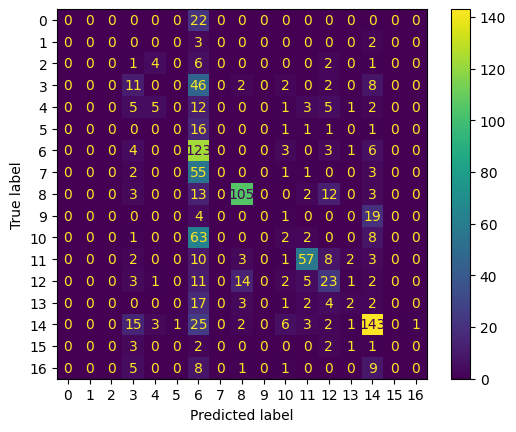

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        22
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00        14
           3       0.20      0.15      0.17        71
           4       0.38      0.15      0.21        34
           5       0.00      0.00      0.00        20
           6       0.28      0.88      0.43       140
           7       0.00      0.00      0.00        62
           8       0.81      0.76      0.78       138
           9       0.00      0.00      0.00        24
          10       0.09      0.03      0.04        76
          11       0.75      0.66      0.70        86
          12       0.36      0.37      0.37        62
          13       0.22      0.06      0.10        31
          14       0.67      0.71      0.69       202
          15       0.00      0.00      0.00         9
          16       0.00      0.00      0.00        24

    accuracy              

In [15]:
calculate_confusion_matrix(base_model,test_data_unbalanced)

## we can notice that the model is underfitted and the 0.46 accuracy is not indicator because of classes in-balance

## To handle the class imbalance problem we can use class weights to give more weight to the minority classes and less weight to the majority classes

In [16]:
import numpy as np
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',classes=np.unique(train_df['label']),y=train_df['label'])
class_weight_dict = dict(enumerate(class_weights))
class_weight_dict

{0: 2.7394957983193278,
 1: 13.697478991596638,
 2: 4.358288770053476,
 3: 0.8374004623683534,
 4: 1.7433155080213905,
 5: 2.9963235294117645,
 6: 0.4290038162916173,
 7: 0.9588235294117647,
 8: 0.4328774399150179,
 9: 2.4904507257448434,
 10: 0.7957041737856968,
 11: 0.6947996589940324,
 12: 0.9734249029561063,
 13: 1.9370172311348781,
 14: 0.2963905809619056,
 15: 7.10239651416122,
 16: 2.556862745098039}

In [17]:
os.makedirs('weighted_base_model_checkpoints',exist_ok=True)
checkpoint_path = 'weighted_base_model_checkpoints/checkpoint'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                save_weights_only=True,
                                                save_best_only=True,
                                                monitor='val_accuracy',
                                                verbose=1)

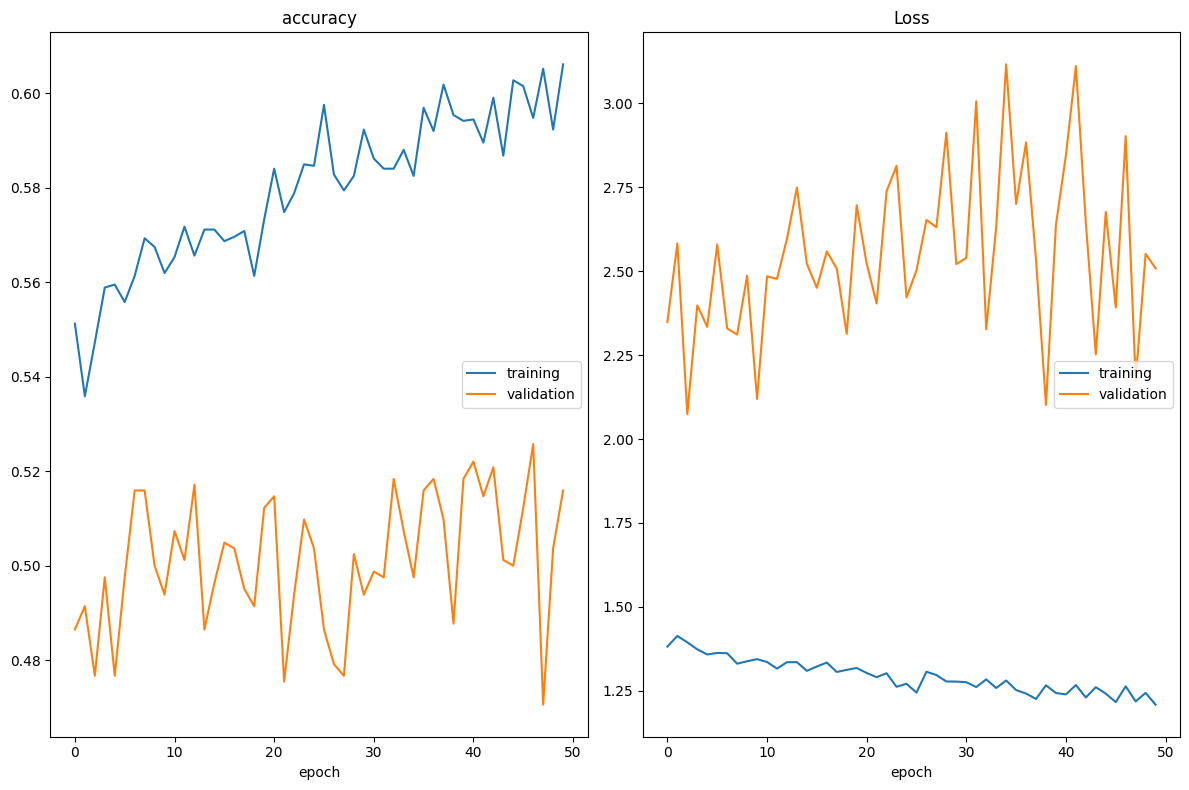

accuracy
	training         	 (min:    0.536, max:    0.606, cur:    0.606)
	validation       	 (min:    0.471, max:    0.526, cur:    0.516)
Loss
	training         	 (min:    1.209, max:    1.414, cur:    1.209)
	validation       	 (min:    2.074, max:    3.116, cur:    2.508)

Epoch 50: val_accuracy did not improve from 0.52574
64/64 [==============================] - 1s 21ms/step - loss: 2.6601 - accuracy: 0.4931


[2.6601150035858154, 0.4931372404098511]

In [18]:
from livelossplot import PlotLossesKeras
base_model_plot_losses_classes_weights = PlotLossesKeras()
base_model = keras.Model(inputs=inputs, outputs=outputs)
base_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
base_model.fit(train_data_without_augmentation, validation_data=val_data, epochs=50,callbacks=[base_model_plot_losses_classes_weights,checkpoint_callback])
base_model.evaluate(test_data_unbalanced)

1/1 [==============================] - 0s 19ms/step


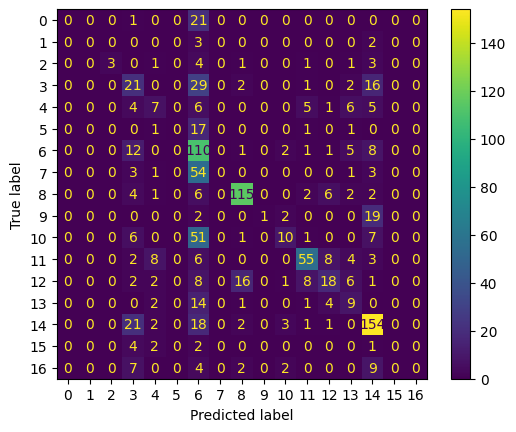

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        22
           1       0.00      0.00      0.00         5
           2       1.00      0.21      0.35        14
           3       0.24      0.30      0.27        71
           4       0.26      0.21      0.23        34
           5       0.00      0.00      0.00        20
           6       0.31      0.79      0.44       140
           7       0.00      0.00      0.00        62
           8       0.82      0.83      0.82       138
           9       1.00      0.04      0.08        24
          10       0.50      0.13      0.21        76
          11       0.71      0.64      0.67        86
          12       0.46      0.29      0.36        62
          13       0.24      0.29      0.26        31
          14       0.66      0.76      0.71       202
          15       0.00      0.00      0.00         9
          16       0.00      0.00      0.00        24

    accuracy              

In [19]:
calculate_confusion_matrix(base_model,test_data_unbalanced)

## we can notice that the accuracy increased and now is more accurate because of classes balance ,but still very low ,so this is because of architecture ,so I will use transfer learning with data augmentation.

## Data augmentation using ImageDataGenerator
Save the images in the respective folders for each class to use the flow_from_directory method of ImageDataGenerator and save the augmented images in the same folders

In [20]:
import os
import numpy as np
import cv2
os.makedirs(f'balanced_data',exist_ok=True)
for label in np.unique(df['label']):
    os.makedirs(f'balanced_data/{label}',exist_ok=True)
for i in range(len(df)):
    img=cv2.imread(f'images_compressed/{df.iloc[i,0]}')
    cv2.imwrite(f'balanced_data/{df.iloc[i,1]}/{df.iloc[i,0]}',img)

### Augment the images using ImageDataGenerator and the dataset balanced with 500 images per class and save the augmented images in the same folders

In [21]:
import os
from keras.utils import load_img,img_to_array
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
import random
path='balanced_data/'
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=.3,
        height_shift_range=.3,
        horizontal_flip=True,
        fill_mode='nearest',
        zoom_range=.3,
    )
for folder in os.listdir(path):
    in_path=os.path.join(path,folder)
    number_of_images=len(os.listdir(in_path))
    if number_of_images < 500:
        while number_of_images < 500 :
            number_of_images=len(os.listdir(in_path))
            required_images=500-number_of_images
            arr=[]
            for image in os.listdir(in_path) :
                image_path=os.path.join(in_path,image)
                img=img_to_array(load_img(image_path))
                img=cv2.resize(img,(224,224))
                arr.append(img)
            arr=np.array(arr)
            it = datagen.flow(arr, batch_size=required_images,save_to_dir=in_path)
            batch = it.next()
    else :
        required_images_delete=number_of_images-500
        deleted_images=random.sample(os.listdir(in_path),k=required_images_delete)
        for image in deleted_images:
            image_path=os.path.join(in_path,image)
            os.remove(image_path)
    for i,image in enumerate(os.listdir(in_path)):
        old_name=os.path.join(in_path,image)
        new_name=os.path.join(in_path,f'{folder}_{i}{image[-4:]}')
        os.rename(old_name,new_name)

for folder in os.listdir(path):
    in_path=os.path.join(path,folder)
    number_of_images=len(os.listdir(in_path))
    print(number_of_images)

500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500
500


## Split the data into train and test sets

In [22]:
import shutil
import os
import numpy as np
import argparse

def get_files_from_folder(path):
    files = os.listdir(path)
    return np.asarray(files)

def image_train_test_split(path_to_data, path_to_test_data, train_ratio):
    # get dirs
    _, dirs, _ = next(os.walk(path_to_data))

    # calculates how many train data per class
    data_counter_per_class = np.zeros((len(dirs)))
    for i in range(len(dirs)):
        path = os.path.join(path_to_data, dirs[i])
        files = get_files_from_folder(path)
        data_counter_per_class[i] = len(files)
    test_counter = np.round(data_counter_per_class * (1 - train_ratio))

    # transfers files
    for i in range(len(dirs)):
        path_to_original = os.path.join(path_to_data, dirs[i])
        path_to_save = os.path.join(path_to_test_data, dirs[i])

        #creates dir
        if not os.path.exists(path_to_save):
            os.makedirs(path_to_save)
        files = get_files_from_folder(path_to_original)
        # moves data
        for j in range(int(test_counter[i])):
            dst = os.path.join(path_to_save, files[j])
            src = os.path.join(path_to_original, files[j])
            shutil.move(src, dst)


In [23]:
os.makedirs(f'test_data',exist_ok=True)
image_train_test_split('balanced_data','test_data',0.8)
os.rename('balanced_data','train_data')

## Transfer learning using pretrained models and save the model

In [1]:
train_data = ImageDataGenerator(rescale=1./255,validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255,)
train_generator = train_data.flow_from_directory(
    directory=r"train_data",
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',subset='training',shuffle=True)
val_generator = train_data.flow_from_directory(
    directory=r"train_data",
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',subset='validation',shuffle=True)
test_generator = test_datagen.flow_from_directory(
    directory=r"test_data",
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',shuffle=False)

Found 5440 images belonging to 17 classes.
Found 1360 images belonging to 17 classes.
Found 1700 images belonging to 17 classes.


In [26]:
!pip install efficientnet

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 795.4 kB/s eta 0:00:00MB/s eta 0:00:01

[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [59]:
from keras.optimizers import RMSprop,Adam
from keras.layers import Dense, Dropout, Flatten
from keras.models import Model
import efficientnet.tfkeras as efn
efn_model = efn.EfficientNetB0(input_shape = (target_size[0], target_size[1], 3), include_top = False, weights = 'imagenet')
x = efn_model.output
x = Flatten()(x)
x = Dropout(0.4)(x)
x = Dense(32, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(128, activation="relu")(x)
predictions = Dense(number_of_classes, activation="softmax")(x)
efficient_net = Model(efn_model.input,predictions)
efficient_net.compile(optimizer=RMSprop(learning_rate=0.0001, decay=1e-6),loss='categorical_crossentropy',metrics=['accuracy'])
efficient_net.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn (BatchNormalization)   (None, 112, 112, 32  128         ['stem_conv[0][0]']              
                                )                                                           

 ivation)                                                                                         
                                                                                                  
 block2b_dwconv (DepthwiseConv2  (None, 56, 56, 144)  1296       ['block2b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block2b_bn (BatchNormalization  (None, 56, 56, 144)  576        ['block2b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block2b_activation (Activation  (None, 56, 56, 144)  0          ['block2b_bn[0][0]']             
 )                                                                                                
          

                                                                                                  
 block3b_se_squeeze (GlobalAver  (None, 240)         0           ['block3b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block3b_se_reshape (Reshape)   (None, 1, 1, 240)    0           ['block3b_se_squeeze[0][0]']     
                                                                                                  
 block3b_se_reduce (Conv2D)     (None, 1, 1, 10)     2410        ['block3b_se_reshape[0][0]']     
                                                                                                  
 block3b_se_expand (Conv2D)     (None, 1, 1, 240)    2640        ['block3b_se_reduce[0][0]']      
                                                                                                  
 block3b_s

 block4b_se_excite (Multiply)   (None, 14, 14, 480)  0           ['block4b_activation[0][0]',     
                                                                  'block4b_se_expand[0][0]']      
                                                                                                  
 block4b_project_conv (Conv2D)  (None, 14, 14, 80)   38400       ['block4b_se_excite[0][0]']      
                                                                                                  
 block4b_project_bn (BatchNorma  (None, 14, 14, 80)  320         ['block4b_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block4b_drop (FixedDropout)    (None, 14, 14, 80)   0           ['block4b_project_bn[0][0]']     
                                                                                                  
 block4b_a

 block5a_project_bn (BatchNorma  (None, 14, 14, 112)  448        ['block5a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5b_expand_conv (Conv2D)   (None, 14, 14, 672)  75264       ['block5a_project_bn[0][0]']     
                                                                                                  
 block5b_expand_bn (BatchNormal  (None, 14, 14, 672)  2688       ['block5b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block5b_expand_activation (Act  (None, 14, 14, 672)  0          ['block5b_expand_bn[0][0]']      
 ivation)                                                                                         
          

 block6a_expand_bn (BatchNormal  (None, 14, 14, 672)  2688       ['block6a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block6a_expand_activation (Act  (None, 14, 14, 672)  0          ['block6a_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block6a_dwconv (DepthwiseConv2  (None, 7, 7, 672)   16800       ['block6a_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block6a_bn (BatchNormalization  (None, 7, 7, 672)   2688        ['block6a_dwconv[0][0]']         
 )        

 )                                                                                                
                                                                                                  
 block6c_activation (Activation  (None, 7, 7, 1152)  0           ['block6c_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block6c_se_squeeze (GlobalAver  (None, 1152)        0           ['block6c_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6c_se_reshape (Reshape)   (None, 1, 1, 1152)   0           ['block6c_se_squeeze[0][0]']     
                                                                                                  
 block6c_s

 block7a_se_squeeze (GlobalAver  (None, 1152)        0           ['block7a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block7a_se_reshape (Reshape)   (None, 1, 1, 1152)   0           ['block7a_se_squeeze[0][0]']     
                                                                                                  
 block7a_se_reduce (Conv2D)     (None, 1, 1, 48)     55344       ['block7a_se_reshape[0][0]']     
                                                                                                  
 block7a_se_expand (Conv2D)     (None, 1, 1, 1152)   56448       ['block7a_se_reduce[0][0]']      
                                                                                                  
 block7a_se_excite (Multiply)   (None, 7, 7, 1152)   0           ['block7a_activation[0][0]',     
          

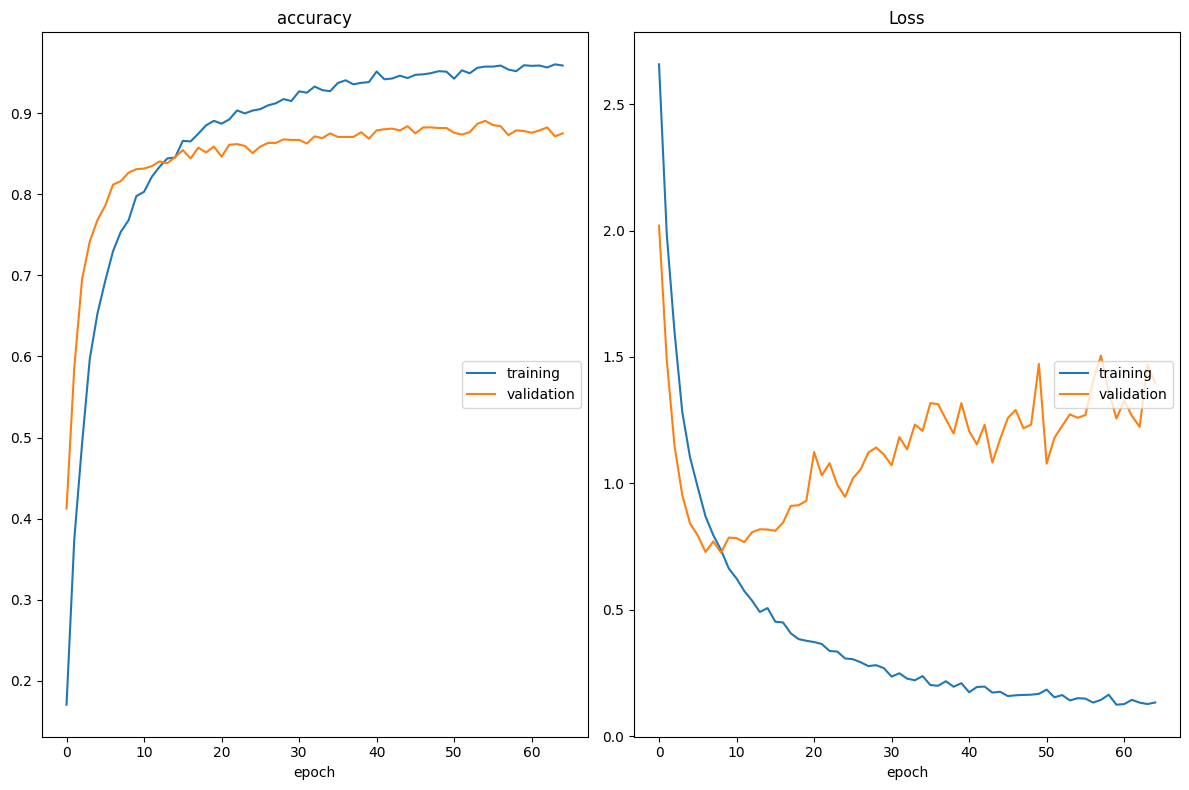

accuracy
	training         	 (min:    0.171, max:    0.960, cur:    0.959)
	validation       	 (min:    0.412, max:    0.890, cur:    0.875)
Loss
	training         	 (min:    0.124, max:    2.658, cur:    0.133)
	validation       	 (min:    0.726, max:    2.020, cur:    1.397)
340/340 [==============================] - 33s 97ms/step - loss: 0.1327 - accuracy: 0.9586 - val_loss: 1.3975 - val_accuracy: 0.8750
saved


In [28]:
import tensorflow as tf
checkpoint_filepath = 'EfficientNet_Checkpoints/'
# efficient_net.load_weights(checkpoint_filepath)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
model_early_stopping_callback=tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=10,
    verbose=0,
    mode="max",
)
eff_history = efficient_net.fit(train_generator,
                                epochs = 100, callbacks=[model_checkpoint_callback,
                                                        model_early_stopping_callback,
                                                         PlotLossesKeras()
                                                       ]
                                ,validation_data=val_generator)
# The model weights (that are considered the best) are loaded into the model.
efficient_net.load_weights(checkpoint_filepath)
efficient_net.save("EfficientNet_model.h5")
print('saved')

In [3]:
import tensorflow as tf
from efficientnet.tfkeras import EfficientNetB0
from keras.models import load_model
model= load_model('EfficientNet_model.h5')
model.evaluate(test_generator)

107/107 [==============================] - 13s 87ms/step - loss: 0.9264 - accuracy: 0.9247


[0.9264256954193115, 0.9247058629989624]

## Load the balanced test data without image data generator to calculate the confusion matrix

Found 1700 files belonging to 17 classes.
1/1 [==============================] - 0s 43ms/step


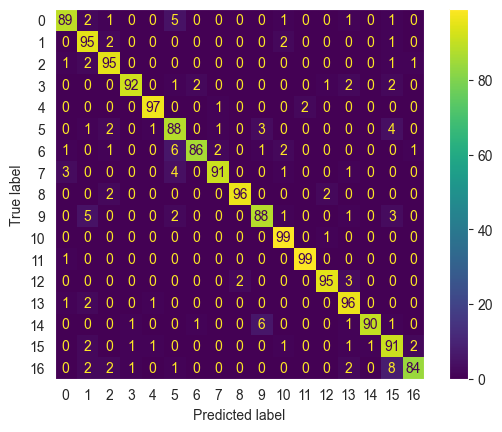

              precision    recall  f1-score   support

           0       0.93      0.89      0.91       100
           1       0.86      0.95      0.90       100
           2       0.90      0.95      0.93       100
           3       0.97      0.92      0.94       100
           4       0.97      0.97      0.97       100
           5       0.82      0.88      0.85       100
           6       0.97      0.86      0.91       100
           7       0.96      0.91      0.93       100
           8       0.98      0.96      0.97       100
           9       0.90      0.88      0.89       100
          10       0.93      0.99      0.96       100
          11       0.98      0.99      0.99       100
          12       0.96      0.95      0.95       100
          13       0.89      0.96      0.92       100
          14       0.99      0.90      0.94       100
          15       0.81      0.91      0.86       100
          16       0.95      0.84      0.89       100

    accuracy              

In [21]:
import tensorflow as tf
test_data_loader = tf.keras.preprocessing.image_dataset_from_directory(
    directory='test_data',
    labels='inferred',
    label_mode='categorical',
    batch_size=16,
    image_size=(224, 224),
    class_names=test_generator.class_indices
)
# Normalize the data
def process(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

test_data_loader = test_data_loader.map(process)
calculate_confusion_matrix(model,test_data_loader)

## Grad-CAM visualization of the Last Receptive Field of the model

In [14]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    array/=255.0
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


1/1 [==============================] - 1s 1s/step
0


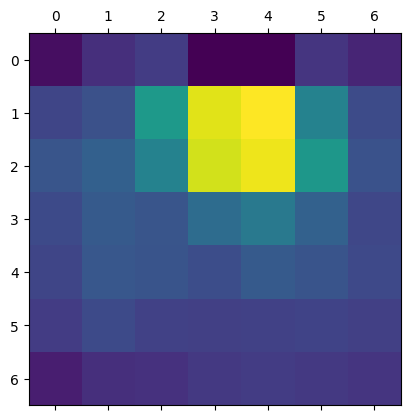

In [15]:
import tensorflow as tf
from efficientnet.tfkeras import EfficientNetB0
from keras.models import load_model
from tensorflow import keras
import matplotlib.pyplot as plt
model= load_model('EfficientNet_model.h5')
# Prepare image
img_array = get_img_array('test_data/Blazer/Blazer_0.jpg', size=(224, 224))
print(model.predict(img_array)[0].argmax())
last_conv_layer_name = "top_conv"


# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

C:\Users\kirolos\AppData\Local\Temp\ipykernel_24996\1841470586.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


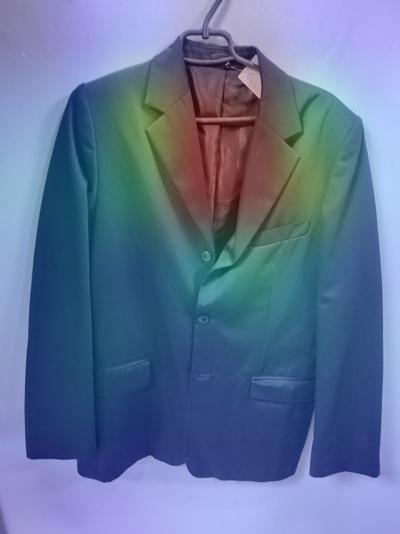

In [16]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam('test_data/Blazer/Blazer_0.jpg', heatmap)

## Using this visualization we can see that the model is focusing on the correct region of the image to make the prediction of the class.

## Calculate the FLOPS and MACCS

In [4]:
def net_flops(nn_model):
    print('%25s | %16s | %16s | %16s | %16s | %6s | %6s |   %6s' % (
        'Layer Name', 'Input Shape', 'Output Shape', 'Kernel Size', 'Filters', 'Strides', 'FLOPS','MACC'))
    print('-' * 150)
    t_flops = 0
    t_macc = 0
    for l in nn_model.layers:

        o_shape, i_shape, strides, ks, filters = ['', '', ''], ['', '', ''], [1, 1], [0, 0], [0, 0]
        flops = 0
        macc = 0
        name = l.name

        factor = 1000000

        if 'InputLayer' in str(l):
            i_shape = l.input.get_shape()[1:4].as_list()
            o_shape = i_shape

        if 'Reshape' in str(l):
            i_shape = l.input.get_shape()[1:4].as_list()
            o_shape = l.output.get_shape()[1:4].as_list()

        if 'Add' in str(l) or 'Maximum' in str(l) or 'Concatenate' in str(l):
            i_shape = l.input[0].get_shape()[1:4].as_list() + [len(l.input)]
            o_shape = l.output.get_shape()[1:4].as_list()
            flops = (len(l.input) - 1) * i_shape[0] * i_shape[1] * i_shape[2]

        if 'Average' in str(l) and 'pool' not in str(l):
            i_shape = l.input[0].get_shape()[1:4].as_list() + [len(l.input)]
            o_shape = l.output.get_shape()[1:4].as_list()
            flops = len(l.input) * i_shape[0] * i_shape[1] * i_shape[2]

        if 'BatchNormalization' in str(l):
            i_shape = l.input.get_shape()[1:4].as_list()
            o_shape = l.output.get_shape()[1:4].as_list()

            bflops = 1
            for i in range(len(i_shape)):
                bflops *= i_shape[i]
            flops /= factor

        if 'Activation' in str(l) or 'activation' in str(l):
            i_shape = l.input.get_shape()[1:4].as_list()
            o_shape = l.output.get_shape()[1:4].as_list()
            bflops = 1
            for i in range(len(i_shape)):
                bflops *= i_shape[i]
            flops /= factor

        if 'pool' in str(l) and ('Global' not in str(l)):
            i_shape = l.input.get_shape()[1:4].as_list()
            strides = l.strides
            ks = l.pool_size
            flops = ((i_shape[0] / strides[0]) * (i_shape[1] / strides[1]) * (ks[0] * ks[1] * i_shape[2]))

        if 'Flatten' in str(l):
            i_shape = l.input.shape[1:4].as_list()
            flops = 1
            out_vec = 1
            for i in range(len(i_shape)):
                flops *= i_shape[i]
                out_vec *= i_shape[i]
            o_shape = flops
            flops = 0

        if 'Dense' in str(l):
            print(l.input)
            i_shape = l.input.shape[1:4].as_list()[0]
            if (i_shape == None):
                i_shape = out_vec

            o_shape = l.output.shape[1:4].as_list()
            flops = 2 * (o_shape[0] * i_shape)
            macc = flops / 2

        if 'Padding' in str(l):
            flops = 0

        if 'Global' in str(l):
            i_shape = l.input.get_shape()[1:4].as_list()
            flops = ((i_shape[0]) * (i_shape[1]) * (i_shape[2]))
            o_shape = [l.output.get_shape()[1:4].as_list(), 1, 1]
            out_vec = o_shape

        if 'Conv2D ' in str(l) and 'DepthwiseConv2D' not in str(l) and 'SeparableConv2D' not in str(l):
            strides = l.strides
            ks = l.kernel_size
            filters = l.filters
            i_shape = l.input.get_shape()[1:4].as_list()
            o_shape = l.output.get_shape()[1:4].as_list()

            if filters == None:
                filters = i_shape[2]

            flops = 2 * ((filters * ks[0] * ks[1] * i_shape[2]) * (
                    (i_shape[0] / strides[0]) * (i_shape[1] / strides[1])))
            macc = flops / 2

        if 'Conv2D ' in str(l) and 'DepthwiseConv2D' in str(l) and 'SeparableConv2D' not in str(l):
            strides = l.strides
            ks = l.kernel_size
            filters = l.filters
            i_shape = l.input.get_shape()[1:4].as_list()
            o_shape = l.output.get_shape()[1:4].as_list()

            if filters == None:
                filters = i_shape[2]

            flops = 2 * (
                    (ks[0] * ks[1] * i_shape[2]) * ((i_shape[0] / strides[0]) * (i_shape[1] / strides[1])))
            macc = flops / 2

        if 'conv' in l.name or 'dense' in l.name:
            t_macc += macc
            t_flops += flops
            print('%25s | %16s | %16s | %16s | %16s | %6s | %5.2f   | %5.2f' % (
                name, str(i_shape), str(o_shape), str(ks), str(filters), str(strides), flops,macc))
    t_flops = t_flops / factor

    print('\nTotal FLOPS (x 10^6): %10.8f\n' % (t_flops))
    print('\nTotal MACCs: %10.8f\n' % (t_macc))

    return t_flops, t_macc

1/1 [==============================] - 4s 4s/step


## Baseline model FLOPs and MACCs

In [25]:
net_flops(base_model)

               Layer Name |      Input Shape |     Output Shape |      Kernel Size |          Filters | Strides |  FLOPS |     MACC
------------------------------------------------------------------------------------------------------------------------------------------------------
                   conv2d |    [224, 224, 3] |  [222, 222, 128] |           (3, 3) |              128 | (1, 1) | 346816512.00   | 173408256.00
                 conv2d_1 |  [111, 111, 128] |  [109, 109, 128] |           (3, 3) |              128 | (1, 1) | 3633610752.00   | 1816805376.00
                 conv2d_2 |    [54, 54, 128] |     [52, 52, 64] |           (3, 3) |               64 | (1, 1) | 429981696.00   | 214990848.00
KerasTensor(type_spec=TensorSpec(shape=(None, 43264), dtype=tf.float32, name=None), name='flatten/Reshape:0', description="created by layer 'flatten'")
                    dense |            43264 |             [64] |           [0, 0] |           [0, 0] | [1, 1] | 5537792.00   | 276889

(4415.948928, 2207974464.0)

## EfficientNet model with class weights FLOPs and MACCs

In [23]:
net_flops(model)

               Layer Name |      Input Shape |     Output Shape |      Kernel Size |          Filters | Strides |  FLOPS |     MACC
------------------------------------------------------------------------------------------------------------------------------------------------------
                stem_conv |    [224, 224, 3] |   [112, 112, 32] |           (3, 3) |               32 | (2, 2) | 21676032.00   | 10838016.00
           block1a_dwconv |   [112, 112, 32] |   [112, 112, 32] |           (3, 3) |               32 | (1, 1) | 7225344.00   | 3612672.00
     block1a_project_conv |   [112, 112, 32] |   [112, 112, 16] |           (1, 1) |               16 | (1, 1) | 12845056.00   | 6422528.00
      block2a_expand_conv |   [112, 112, 16] |   [112, 112, 96] |           (1, 1) |               96 | (1, 1) | 38535168.00   | 19267584.00
           block2a_dwconv |   [112, 112, 96] |     [56, 56, 96] |           (3, 3) |               96 | (2, 2) | 5419008.00   | 2709504.00
     block2a_proj

(771.841728, 385920864.0)

# Final results
| Model                 | input_size | Accuracy | Params<br>(M) | FLOPs<br>(M) | MACC<br>(M) |                                                                                         weights                                                                                         |
|-----------------------|:----------:|:--------:|:-------------:|:------------:|:-----------:|:---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------:|
| Baseline              |    224     |    46    |      2.9      |    4415.9    |   2207.9    | [weights](https://uottawa-my.sharepoint.com/personal/kataa028_uottawa_ca/_layouts/15/guestaccess.aspx?docid=00e804f4a57704c0f94447a4418c42796&authkey=AWEJbTCAoUnnIodAol-vB58&e=RVGABg) |
| Baseline_class_wights |    224     |    49    |      2.9      |    4415.9    |   2207.9    | [weights](https://uottawa-my.sharepoint.com/personal/kataa028_uottawa_ca/_layouts/15/guestaccess.aspx?docid=05f322888f02a4d7e8f4bc3ca28c413fb&authkey=AZALgV2cgTSBaBuySbIjAME&e=7CvnuZ) |
| EfficientNet          |    224     |    92    |     6.06      |    771.84    |    385.9    |                                                                                       [weights](https://uottawa-my.sharepoint.com/personal/kataa028_uottawa_ca/_layouts/15/guestaccess.aspx?docid=0bae61e4f3dca44d38cfba4e1658f934d&authkey=AaZ18tlHYFDVpPZDM1XylOg&e=Jhz83F)                                                                                       |

## Models Optimizations to reduce FLOPs and MACCs and size of the model

### Quantization post training

In [26]:
import tensorflow as tf

model = tf.keras.models.load_model('EfficientNet_model.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_tflite_model = converter.convert()
open("quantized_model.tflite", "wb").write(quantized_tflite_model)

INFO:tensorflow:Assets written to: C:\Users\kirolos\AppData\Local\Temp\tmpnbsu3lj7\assets


INFO:tensorflow:Assets written to: C:\Users\kirolos\AppData\Local\Temp\tmpnbsu3lj7\assets


6551616

## Test quantized model

In [5]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1./255,)
target_size = (224, 224)
number_of_classes = 17
test_generator = test_datagen.flow_from_directory(
    directory=r"test_data",
    target_size=target_size,
    batch_size=16,
    class_mode='categorical',shuffle=False)
test_data_loader_1 = tf.keras.preprocessing.image_dataset_from_directory(
    directory='test_data',
    labels='inferred',
    label_mode='categorical',
    batch_size=1,
    image_size=(224, 224),
    class_names=test_generator.class_indices
)
# Normalize the data
def process(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

test_data_loader_1 = test_data_loader_1.map(process)

Found 1700 images belonging to 17 classes.
Found 1700 files belonging to 17 classes.


In [11]:
import tensorflow as tf
interpreter = tf.lite.Interpreter(model_path='quantized_model.tflite')
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
# Initialize empty lists for storing predictions and ground truth labels
predicted_labels = []
true_labels = []

# Iterate over evaluation dataset
for i,(input_data, target) in tqdm(enumerate(test_data_loader_1)):
    # Set input tensor
    interpreter.set_tensor(input_details[0]['index'], input_data)

    # Run inference
    interpreter.invoke()

    # Get output tensor
    output_data = interpreter.get_tensor(output_details[0]['index'])

    # Process the output data
    predicted_label = np.argmax(output_data, axis=1)

    # Append predicted and true labels to the lists
    predicted_labels.append(predicted_label)
    true_labels.append(target.numpy().argmax(axis=1))

# Convert the lists to numpy arrays
predicted_labels = np.concatenate(predicted_labels)
true_labels = np.concatenate(true_labels)

# Calculate evaluation metrics

accuracy = accuracy_score(true_labels, predicted_labels)

# Print the evaluation metrics
print("Accuracy:", accuracy)



1700it [1:25:36,  3.02s/it]

Accuracy: 0.9211764705882353


## It gives the same accuracy as the original model but the inference time is slower than the original model it takes 3.2 s to predict one image.

## Calculate FLOPs and MACCs of quantized model

In [41]:
import tensorflow as tf
import numpy as np

def calculate_flops_quantized_model(model_path):
    # Load the quantized model
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()

    ops = interpreter._get_ops_details()

    # Calculate the FLOPs for each operation
    total_flops = 0
    for op in ops:
        try :
            # Get the input and output tensor shapes for the operation
            input_shape = interpreter.get_tensor(op['inputs'][0]).shape
            output_shape = interpreter.get_tensor(op['outputs'][0]).shape

            # Calculate the number of FLOPs for the operation
            flops = np.prod(output_shape)

            # Accumulate the FLOPs for all operations
            total_flops += flops
        except:
            pass
    return total_flops

# Example usage
model_path = 'quantized_model.tflite'
flops = calculate_flops_quantized_model(model_path)
print("Total FLOPs: {:.2f}".format(flops ))


Total FLOPs: 2408487.00


# Final results
| Model                  | input_size | Accuracy | Params<br>(M) | FLOPs<br>(M) | MACC<br>(M) |                                                                                         weights                                                                                         |
|------------------------|:----------:|:--------:|:-------------:|:------------:|:-----------:|:---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------:|
| Baseline               |    224     |    46    |      2.9      |    4415.9    |   2207.9    | [weights](https://uottawa-my.sharepoint.com/personal/kataa028_uottawa_ca/_layouts/15/guestaccess.aspx?docid=00e804f4a57704c0f94447a4418c42796&authkey=AWEJbTCAoUnnIodAol-vB58&e=RVGABg) |
| Baseline_class_wights  |    224     |    49    |      2.9      |    4415.9    |   2207.9    | [weights](https://uottawa-my.sharepoint.com/personal/kataa028_uottawa_ca/_layouts/15/guestaccess.aspx?docid=05f322888f02a4d7e8f4bc3ca28c413fb&authkey=AZALgV2cgTSBaBuySbIjAME&e=7CvnuZ) |
| EfficientNet           |    224     |    92    |     6.06      |    771.84    |    385.9    | [weights](https://uottawa-my.sharepoint.com/personal/kataa028_uottawa_ca/_layouts/15/guestaccess.aspx?docid=0bae61e4f3dca44d38cfba4e1658f934d&authkey=AaZ18tlHYFDVpPZDM1XylOg&e=Jhz83F) |
| Quantized EfficientNet |    224     |    92    |       -       |     2.4      |      -      | [weights](https://uottawa-my.sharepoint.com/personal/kataa028_uottawa_ca/_layouts/15/guestaccess.aspx?docid=0e121b21653774015b143aabd9d93cfc5&authkey=AcNZKU1PE6JTWHEnAjQeDFQ&e=xoz6VF) |

The number of parameters and FLOPs of the quantized model is decreased from 771.84 M to only 2.4 M

### Pruning
To try pruning we will repeat the training process with the same model but with pruning applied to the model by calculating the parameters importance and removing the least important ones and fine tune the model again .we can also repeat the process until we reach the desired sparsity.<br>
**According to the limited time I can't do it because the training process takes approximately 5 hours**

## This is the code to apply pruning to the model but I can't run it because of the limited time

In [ ]:
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.sparsity import keras as sparsity
pruning_params = {
    'pruning_schedule': sparsity.PolynomialDecay(initial_sparsity=0.50,
                                                 final_sparsity=0.90,
                                                 begin_step=0,
                                                 end_step=1000,
                                                 frequency=100)
}
pruned_model = tfmot.sparsity.keras.prune_low_magnitude(base_model, **pruning_params)
